# PyTorch's Autograd

In the previous network we explore using gradient descent with an $L_2$ loss function to fit a linear model to our data. This a was done by manually defining our gradient functions for the update step.  
In this notebook we use PyTorch's autogradient functionality to reimplement the procedure. 

In [1]:
import torch as T

In [2]:
# Our data (again)
# temperatures in unknown units
temp_x = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
# temperatures in celsius. 
temp_y = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
assert(len(temp_x) == len(temp_y))

# Create tensors for data
t_x = T.tensor(temp_x)
t_y = T.tensor(temp_y)

In [6]:
# Normalize data to be centered at 0 and scaled down by standard deviation. 
mean = t_x.mean()
std = t_x.std()
t_xnorm = t_x - mean
t_xnorm /= std
print("Mean: ", mean)
print("Standard Deviation: ", std)


Mean:  tensor(10.5000)
Standard Deviation:  tensor(9.2114)


In [3]:
# Define model and loss
def model(x, w, b):
    return w*x + b

def loss_fn(y_pred, y_label):
    sqr_diffs = (y_pred - y_label)**2
    return sqr_diffs.mean()

We creating tensors we can set their `requires_grad` attribute to be True (by default their valus is `None`.) Doing so will have PyTorch track the tree resulting from operations on this tensor. When these operations are apart of differential functions, this allows the value of the derivative to be automatically computed. It is then stored in the tensor's `grad` attribute.

In [4]:
params = T.tensor([1.0, 0], requires_grad=True)
print(params.grad)

None


In [14]:
loss = loss_fn(model(t_xnorm, *params), t_y)
# PyTorch computes loss gradient's automatically.
loss.backward()
print(params.grad)

tensor([ -28.1990, -103.6000])


The loss function $wx + b$ corresponds to a unique **autogradient graph**, which is directed and acyclic, where the params (w,b) has be specified to have gradients. Each node of the graph corresponds to either values in our model (i.e. input, output, model params) or mathemical operations (e.g. multiplying, adding, etc.)  
  
By following our input data from its node to the leaf node we can comput the loss according to our model. Then by following graph in the reverse direction we can determine the partial gradients of our model parameters. This occurs by calling `.backward()`.  

**Note:** `.backward()` will accumulate the gradients; we must zero the gradient explicitly are using it to update our parameters by calling `.grad.zero_()` before the next call to `.backward()`.  

Once we have the gradient of our loss computed, we can update our parameters using our update rule. We use Python's `with` statement to ensure the autograd mechanism does not attempt to add this update rule's operations to the autogradient graph. 

In [20]:
def train(n_epochs, lr, params, x, y_label):
    for epoch in range(1, n_epochs+1):
        if params.grad is not None:
            params.grad.zero_()
        
        y_pred = model(x, *params)
        loss = loss_fn(y_pred, y_label)
        loss.backward()
        
        with T.no_grad():
            params -= lr * params.grad
            
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch,  float(loss)))
            
    return params


In [21]:
params = train(10000, 0.001, T.tensor([1.0, 0], requires_grad=True), t_xnorm, t_y)

Epoch 500, Loss 409.206085
Epoch 1000, Loss 64.684196
Epoch 1500, Loss 17.347157
Epoch 2000, Loss 10.823331
Epoch 2500, Loss 9.921030
Epoch 3000, Loss 9.795734
Epoch 3500, Loss 9.778260
Epoch 4000, Loss 9.775809
Epoch 4500, Loss 9.775458
Epoch 5000, Loss 9.775415
Epoch 5500, Loss 9.775404
Epoch 6000, Loss 9.775407
Epoch 6500, Loss 9.775407
Epoch 7000, Loss 9.775407
Epoch 7500, Loss 9.775407
Epoch 8000, Loss 9.775407
Epoch 8500, Loss 9.775407
Epoch 9000, Loss 9.775407
Epoch 9500, Loss 9.775407
Epoch 10000, Loss 9.775407


## Different Optimizers

PyTorch includes several optimization algorithms which determines how the model's parameters are updated. In the above we manually updated the model's parameters but this can be done by calling `optimizer.step()` where `optimizer` is one of PyTorch's class implementations of an optimizer algorithm. By default, PyTorch uses the SGD algorithm.  

Below we use the ''Adam'' optimizer which adaptively sets the learning rate and is less sensitive to unscaled inputs.

In [5]:
def train_adam(n_epochs, optimizer, params, x, y_label):
    for epoch in range(1, n_epochs+1):
        if params.grad is not None:
            params.grad.zero_()
        
        y_pred = model(x, *params)
        loss = loss_fn(y_pred, y_label)
        
        # Let optimizer update gradient operations.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch,  float(loss)))
            
    return params


In [6]:
import torch.optim as optim

params = T.tensor([1.0, 0.0], requires_grad=True)
lr = 0.005
opt = optim.Adam([params], lr=lr)

model_adam = train_adam(25000, opt, params, t_x, t_y)

Epoch 500, Loss 488.201538
Epoch 1000, Loss 364.390045
Epoch 1500, Loss 327.954254
Epoch 2000, Loss 289.853058
Epoch 2500, Loss 251.458511
Epoch 3000, Loss 214.465714
Epoch 3500, Loss 179.943893
Epoch 4000, Loss 148.513367
Epoch 4500, Loss 120.493645
Epoch 5000, Loss 96.007965
Epoch 5500, Loss 75.052238
Epoch 6000, Loss 57.534531
Epoch 6500, Loss 43.295364
Epoch 7000, Loss 32.116959
Epoch 7500, Loss 23.723694
Epoch 8000, Loss 17.779747
Epoch 8500, Loss 13.888503
Epoch 9000, Loss 11.600457
Epoch 9500, Loss 10.440561
Epoch 10000, Loss 9.961552
Epoch 10500, Loss 9.812028
Epoch 11000, Loss 9.779933
Epoch 11500, Loss 9.775711
Epoch 12000, Loss 9.775415
Epoch 12500, Loss 9.775405
Epoch 13000, Loss 9.775404
Epoch 13500, Loss 9.775406
Epoch 14000, Loss 9.775406
Epoch 14500, Loss 9.775407
Epoch 15000, Loss 9.775397
Epoch 15500, Loss 9.775400
Epoch 16000, Loss 9.775403
Epoch 16500, Loss 9.775405
Epoch 17000, Loss 9.775402
Epoch 17500, Loss 9.775399
Epoch 18000, Loss 9.775401
Epoch 18500, Loss 9.

In [7]:
print(params)

tensor([ 1.7924, 32.9812], requires_grad=True)


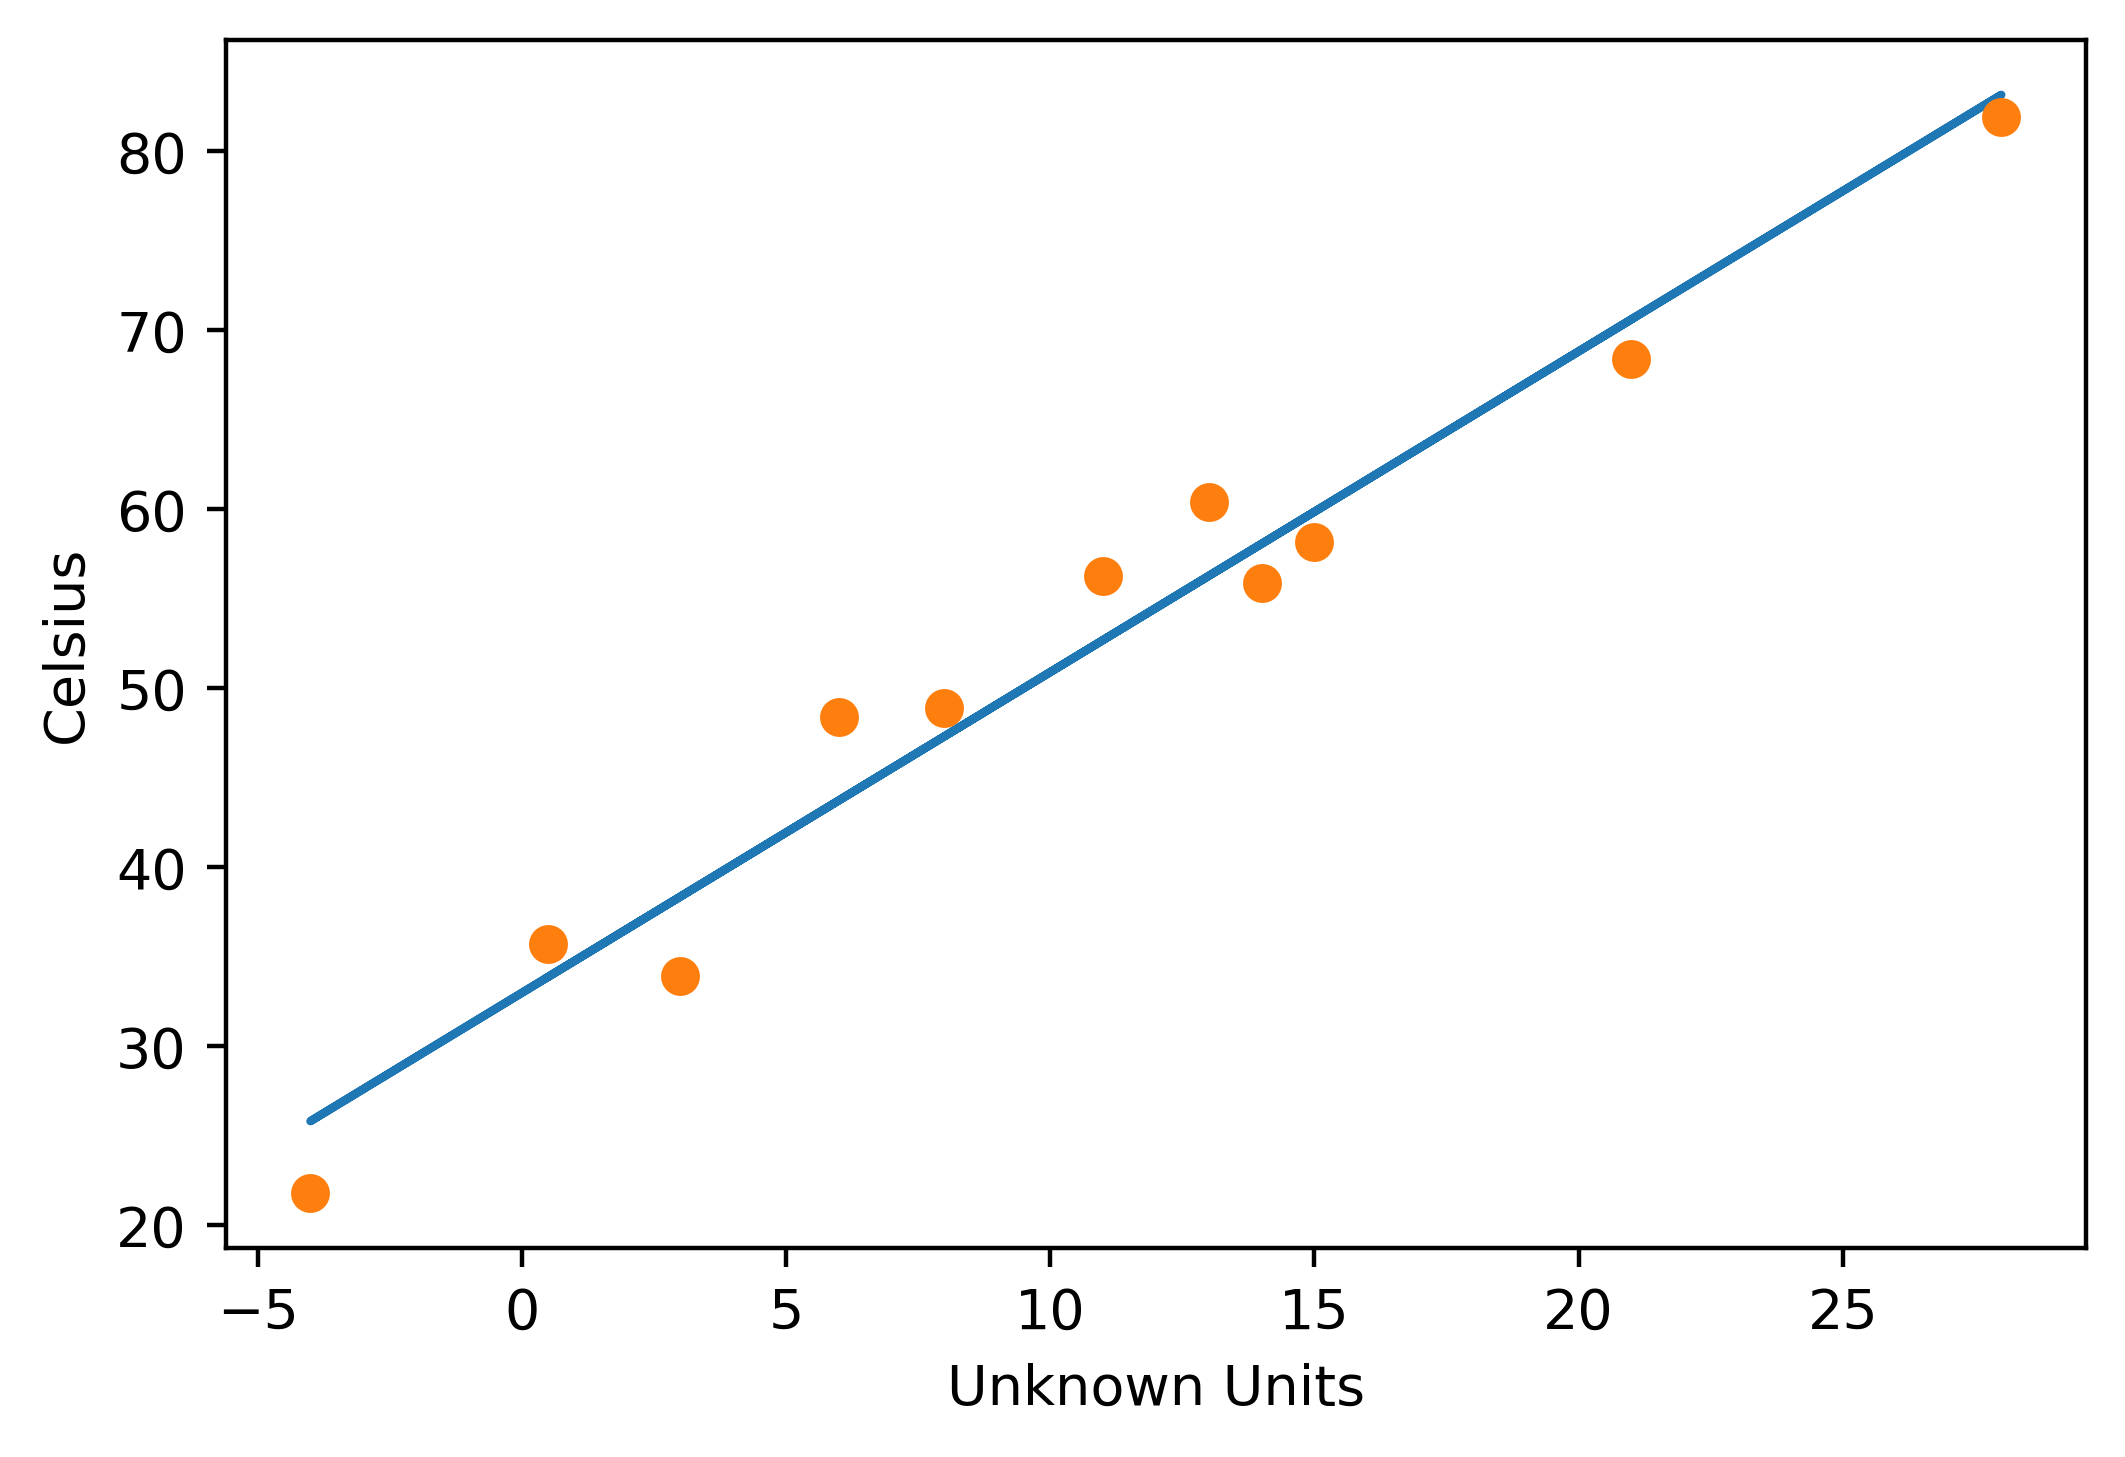

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt

# Plot line resulting from the parameters learned. 
fig = plt.figure(dpi=400)
plt.xlabel("Unknown Units")
plt.ylabel("Celsius")
plt.plot(t_x.numpy(), model(t_x, *params).detach().numpy())
plt.plot(t_x.numpy(), t_y.numpy(), 'o')